In [1]:
#default params
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
enhancers_metadata_path = "Analysis/enhancers/tcea_FANTOM/tcea_FANTOM_enhancers_metadata.txt"
atac_counts_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_enhancer_counts.mtx"
atac_barcodes_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_barcodes.tsv"
atac_features_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_features.tsv"

# Defaults (you can change these when running the notebook)
min_cells <- 10        # X: an enhancer must be seen in at least this many cells
min_enhancers <- 10   # X: a cell must have at least this many enhancers ATAC reads

binarize_threshold = 1



# eRNA count matrix analysis

In [2]:
library(magrittr)
library(dplyr)
library(stringi)
library(ggplot2)
library(Matrix)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [4]:
rna_enhancers = readRDS(filtered_erna_path)

# ATAC counts

In [5]:
atac_counts <- Matrix::readMM(atac_counts_path) %>% as.matrix()

Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 5.0 GiB


In [6]:
atac_barcodes <- read.table(atac_barcodes_path)
atac_features <- read.table(atac_features_path)
rownames(atac_counts) <- atac_features$V1
colnames(atac_counts) <- atac_barcodes$V1 %>% gsub("-1$", "", .)
atac_counts[1:10, 1:10]
dim(atac_counts)

[1] 56065 11909

In [7]:
atac_counts = Matrix(atac_counts,sparse = TRUE)

# ATAC normalization

In [8]:
# Filter
# keep only enhancers that expressed in at least min_cells cells
rows_to_keep = which(rowSums(atac_counts >= 1) >= min_cells)
print(length(rows_to_keep))
print( "enhancers out of " )
print(nrow(atac_counts))

# keep only cells that expressed in at least min_enhancers enhancers
cols_to_keep = which(colSums(atac_counts >= 1) >= min_enhancers)
print(length(cols_to_keep))
print( "cells out of " )
print(ncol(atac_counts))

atac_counts = atac_counts[rows_to_keep, cols_to_keep]

[1] 36978
[1] "enhancers out of "
[1] 56065
[1] 11896
[1] "cells out of "
[1] 11909


In [9]:
cell_sums_atac <- colSums(atac_counts)
# 4. Perform Library Size Normalization (Scaling)
# We divide each cell's counts by its total sum and scale to 10,000 (CP10K)

# 1. Create a diagonal matrix of the inverse of column sums
# Diagonal matrices in the Matrix package are very memory efficient
d_inv <- Diagonal(x = 1 / cell_sums_atac)

# 2. Multiply the counts by the inverse diagonal matrix
# Matrix multiplication (atac_counts %*% d_inv) will scale each column
# and return a sparse matrix (dgCMatrix)
atac_norm <- atac_counts %*% d_inv
colnames(atac_norm) <- colnames(atac_counts)
# 3. Multiply by the scaling factor (10,000)
atac_norm <- atac_norm * 10000

In [11]:
head(atac_norm)
print(summary(atac_norm@x))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.2681    5.1230    8.4034   11.8019   14.0895 2000.0000 


# Set common enhancers and features

In [12]:
print(dim(rna_enhancers))
print(dim(atac_norm))

common_ernas = intersect(rownames(rna_enhancers), rownames(atac_norm))
print(length(common_ernas))
common_cells = intersect(colnames(rna_enhancers), colnames(atac_norm))
print(length(common_cells))

[1] 10457 10513
[1] 36978 11896
[1] 8928
[1] 10502


In [13]:
#set common rownames and colnames
rna_enhancers = rna_enhancers[common_ernas, common_cells]
atac_norm = atac_norm[common_ernas, common_cells]

In [14]:
# clear objects to save memory
rm(atac_barcodes, atac_features)
gc()

           used  (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells  1948090 104.1    3593505   192.0    3168383   169.3
Vcells 24752510 188.9 1929065775 14717.7 2131474456 16261.9

In [15]:
class(rna_enhancers)
class(atac_counts)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [16]:
head(atac_norm)
head(rna_enhancers)
class(rna_enhancers)
class(atac_norm)
dim(rna_enhancers)
dim(atac_norm)

[1]  8928 10502

# Cell type specific enhancers filtering

In [17]:
# read enhancer per cell type files
library(stringi)
library(data.table)
enhancer_per_celltype_df= data.table::fread(cell_type_enhancers_path, header = F, data.table = FALSE, sep = "\t")

data.table 1.17.8 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [18]:
enhancer_per_celltype = enhancer_per_celltype_df[,1]
names(enhancer_per_celltype) = enhancer_per_celltype_df[,2]
head(enhancer_per_celltype)

                       CD8+              CD14+_monocyte                        CD8+                       CD19+ 
  "FANTOM5_1:868565-868684"   "FANTOM5_1:868565-868684" "FANTOM5_1:1008722-1008886" "FANTOM5_1:1008722-1008886" 
                      CD20+                        CD8+ 
"FANTOM5_1:1014834-1015095" "FANTOM5_1:1014834-1015095" 

In [19]:
cell_type_enhancers = unique(enhancer_per_celltype)
length(cell_type_enhancers)
cell_type_enhancers = intersect(cell_type_enhancers, common_ernas)
length(cell_type_enhancers)

[1] 2590

In [21]:
atac_norm = (atac_norm)[cell_type_enhancers, ]
rna_enhancers  = rna_enhancers[cell_type_enhancers, ]
dim(atac_norm)
dim(rna_enhancers)

[1]  2590 10502

In [20]:
library(Matrix)
original_rna_mat = Matrix(rna_enhancers,sparse = TRUE)
original_atac_mat = Matrix(atac_norm,sparse = TRUE)

In [21]:
print(dim(atac_norm))
print(dim(rna_enhancers))

[1]  8928 10502
[1]  8928 10502


# Spearman correlation

In [23]:
rna_enhancers = original_rna_mat %>% as.matrix()
atac_norm = original_atac_mat %>% as.matrix() 

In [24]:
# remove all 0 cells
zero_cells = colSums(atac_norm) == 0 | colSums(rna_enhancers) == 0
atac_norm = atac_norm[, !zero_cells]
rna_enhancers = rna_enhancers[, !zero_cells]

# remove all 0 enhancers
zero_enhancers = rowSums(atac_norm) == 0 | rowSums(rna_enhancers) == 0
atac_norm = atac_norm[!zero_enhancers, ]
rna_enhancers = rna_enhancers[!zero_enhancers, ]

In [25]:
dim(atac_norm)
dim(rna_enhancers)
rna_enhancers = rna_enhancers %>% as.matrix()
atac_norm = atac_norm %>% as.matrix()
class(rna_enhancers)
class(atac_norm)

[1] "matrix" "array" 

In [26]:
# spearman per cell
spearman_per_cell <- mapply(function(x, y){cor(x, y,method = "spearman")}, as.data.frame(rna_enhancers), as.data.frame(atac_norm))


In [27]:
head(spearman_per_cell)

AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT AAACAGCCACCAACCG AAACAGCCAGGATAAC AAACAGCCAGTTTACG 
    -0.020883827     -0.020463499     -0.002510454     -0.009955130      0.044149142      0.050652469 

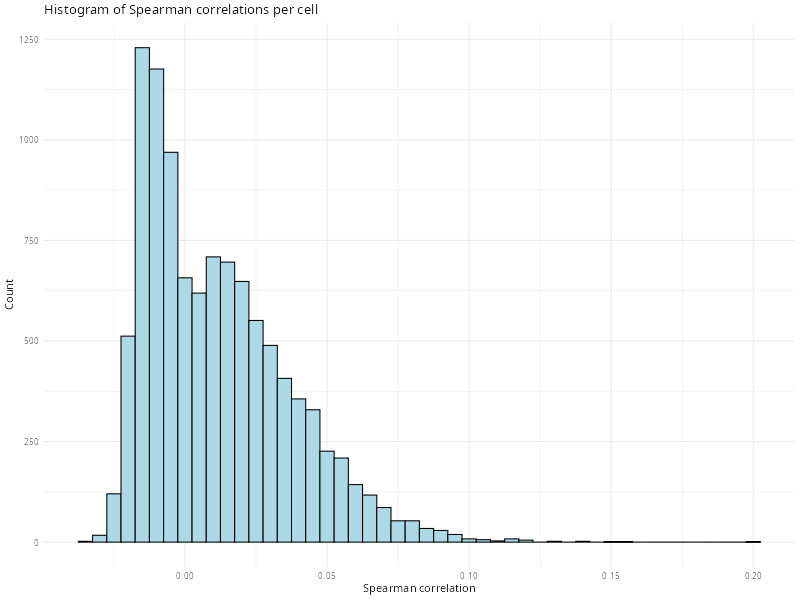

In [28]:
#histogram of spearman correlations with small binwidth
spearman_df = data.frame(spearman = spearman_per_cell)
p = ggplot(spearman_df, aes(x = spearman)) +
  geom_histogram(binwidth = 0.005, fill = "lightblue", color = "black") +
  labs(title = "Histogram of Spearman correlations per cell", x = "Spearman correlation", y = "Count") +
  theme_minimal()
p

# ATAC binary, erna continuous

In [22]:
library(Matrix)
# This creates a compact data frame
df_all <- data.frame(
  eRNA = as.vector(rna_enhancers),
  ATAC_val = as.vector(atac_norm)
)

# 4. Create the Status column efficiently
df_all$ATAC_status <- ifelse(df_all$ATAC_val > 0, "Open", "Closed")


In [23]:
aggregate(eRNA ~ ATAC_status, data = df_all, FUN = mean)

  ATAC_status     eRNA
1      Closed 1.337959
2        Open 2.881627

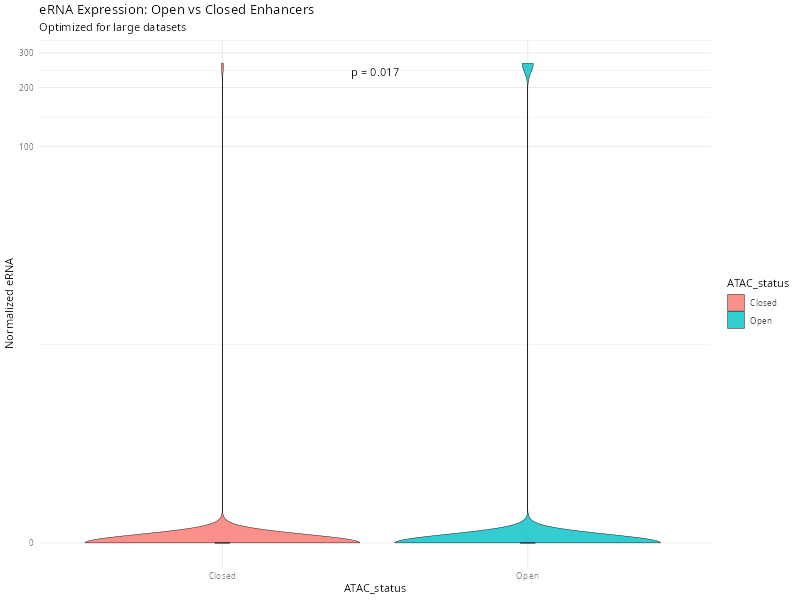

In [ ]:
# Wilcoxon test and plot, testing only on first 1000 rows for speed
p_val <- format.pval(wilcox.test(eRNA ~ ATAC_status, data = df_all[1:1000,])$p.value, digits = 2)

ggplot(df_all[1:1000,], aes(x = ATAC_status, y = eRNA, fill = ATAC_status)) +

  stat_ydensity(
    mapping = aes(fill = ATAC_status),
    geom = "violin",
    position = "dodge",
    alpha = 0.8,
    color = "black",
    linewidth = 0.2,  
    trim = TRUE,
    bw = 0.1       
  ) +
  geom_boxplot(
    width = 0.05, 
    outlier.shape = NA, 
    fill = "white", 
    alpha = 0.5,
    linewidth = 0.3   
  ) +
    scale_y_continuous(trans = "log1p")+
  annotate("text", x = 1.5, y = max(df_all[1:1000,]$eRNA) * 0.9, 
           label = paste("p =", p_val), size = 4) +
  theme_minimal() +
  labs(
    title = "eRNA Expression: Open vs Closed Enhancers",
    subtitle = "Optimized for large datasets",
    y = "Normalized eRNA"
  )

In [26]:
p_val <- format.pval(wilcox.test(eRNA ~ ATAC_status, data = df_all)$p.value, digits = 2)

In [28]:
y_limit <- quantile(df_all$eRNA, 0.995, na.rm = TRUE)
y_limit

  99.5% 
128.667 

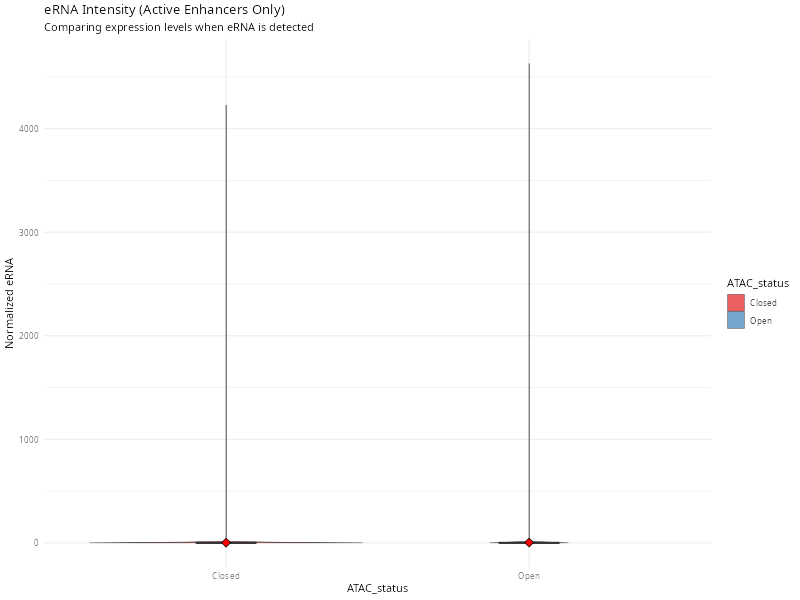

In [29]:
p = ggplot(df_all, aes(x = ATAC_status, y = eRNA, fill = ATAC_status)) +
  stat_ydensity(geom = "violin", alpha = 0.7, linewidth = 0.2) +
  geom_boxplot(width = 0.2, fill = "white", outlier.shape = NA, alpha = 0.5) +
  stat_summary(fun = mean, geom = "point", shape = 23, size = 3, fill = "red") +
  # scale_y_continuous(trans = "log1p")+
  theme_minimal() +
  labs(
    title = "eRNA Intensity (Active Enhancers Only)",
    subtitle = "Comparing expression levels when eRNA is detected",
    y = "Normalized eRNA"
  ) +
  scale_fill_brewer(palette = "Set1")

p


p+  coord_cartesian(ylim = c(0, 20)) +
  annotate("text", x = 1.5, y = 20,label = paste("p =", p_val), size = 4)

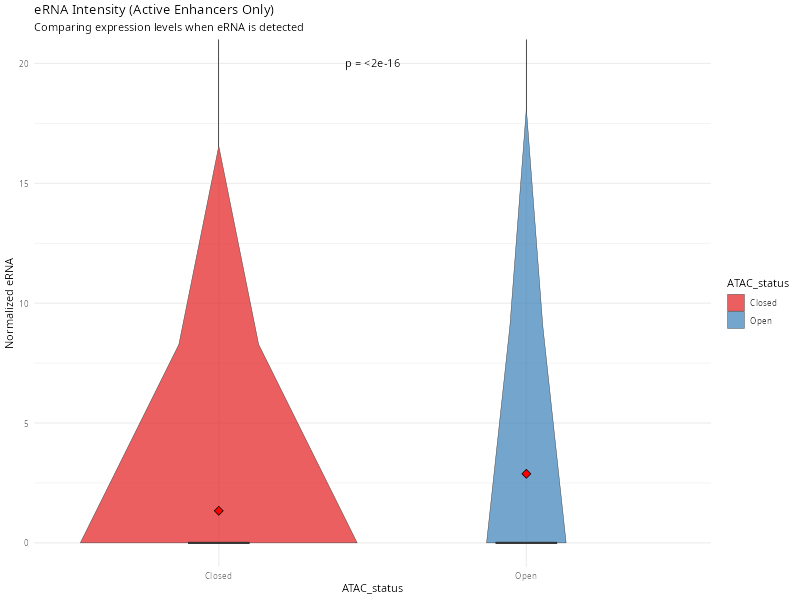

In [30]:
p+  coord_cartesian(ylim = c(0, 20)) +
  annotate("text", x = 1.5, y = 20,label = paste("p =", p_val), size = 4)

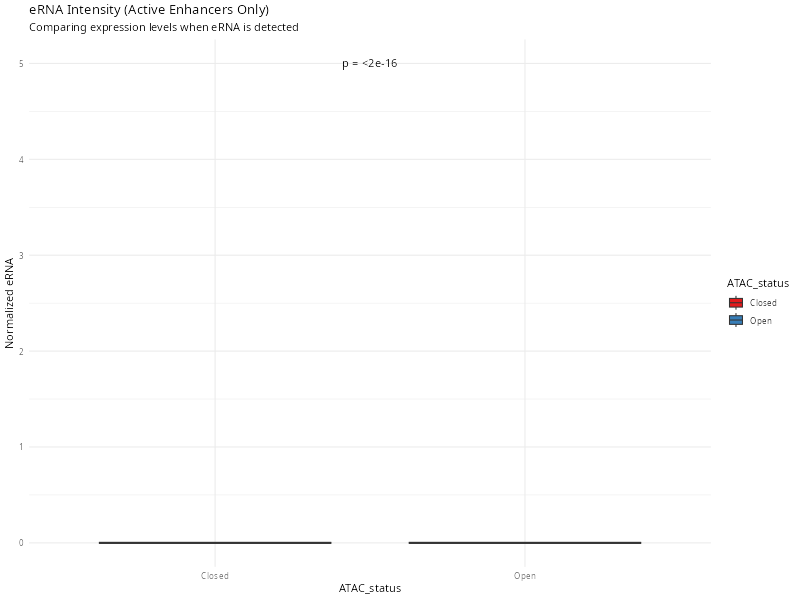

In [33]:
#just boxplot of df_all
p2 = ggplot(df_all, aes(x = ATAC_status, y = eRNA, fill = ATAC_status)) +
  geom_boxplot(outlier.shape = NA) +
  theme_minimal() +
  labs(
    title = "eRNA Intensity (Active Enhancers Only)",
    subtitle = "Comparing expression levels when eRNA is detected",
    y = "Normalized eRNA"
  ) +
  scale_fill_brewer(palette = "Set1")+  
  coord_cartesian(ylim = c(0, 5)) +
  annotate("text", x = 1.5, y = 5,label = paste("p =", p_val), size = 4)

p2

# eRNA- ATAC correlation scatter plots

In [34]:
df = data.frame(
  eRNA = as.vector(rna_enhancers),
  ATAC = as.vector(atac_norm)
)

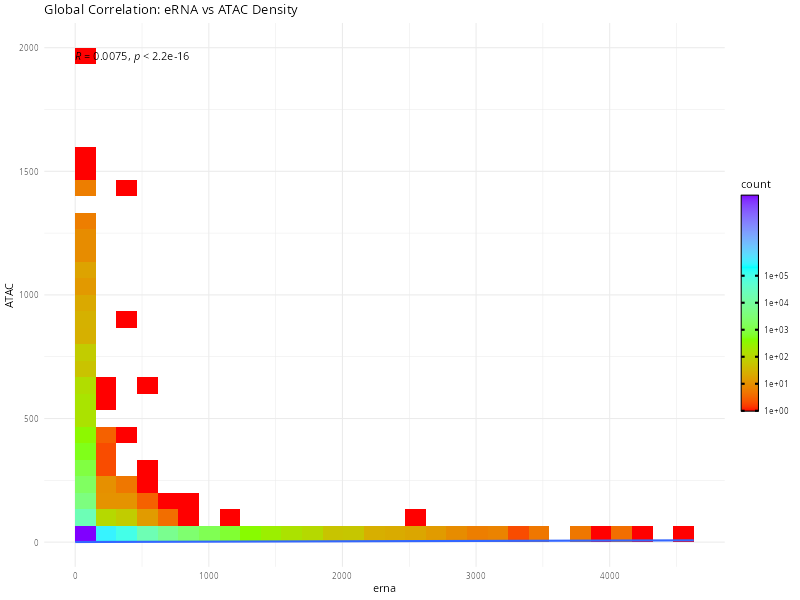

In [35]:
library(ggpubr)
library(scales)
my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
my_values <- rescale(log10(my_breaks), type = "q")

ggplot(df, aes(x = eRNA, y = ATAC)) +
  geom_bin2d(bins = 30) +
  scale_fill_gradientn(colors  = rainbow(4),values = my_values,
  breaks = my_breaks ,trans = "log10") +
  guides(fill = guide_colorbar(
    ticks.colour = "black",
    ticks.linewidth = 1,   
    frame.colour = "black",
    barheight = 15         
  ))+
  #geom_point(alpha = 0.3) +
  theme_minimal() +
  labs(title = "Global Correlation: eRNA vs ATAC Density",x = "erna", y= "ATAC")+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor()

In [36]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = T, sep = "\t", data.table = T)
head(enhancers_metadata)

      chr  start    end                      id   type gene_intersection bp_to_closest_gene length
   <char>  <int>  <int>                  <char> <char>            <char>              <int>  <int>
1:      1 905373 905830 FANTOM5_1:840753-841210      1        intergenic              18093    457
2:      1 910105 910298 FANTOM5_1:845485-845678      1        intergenic              13625    193
3:      1 921159 921377 FANTOM5_1:856539-856757      1        intergenic               2546    218
4:      1 922876 923268 FANTOM5_1:858256-858648      1        intergenic                655    392
5:      1 933185 933304 FANTOM5_1:868565-868684      1          intronic                  0    119
6:      1 983069 983175 FANTOM5_1:918449-918555      1        intergenic                953    106

In [39]:
unique(enhancers_metadata$gene_intersection)

[1] "intergenic" "intronic"  

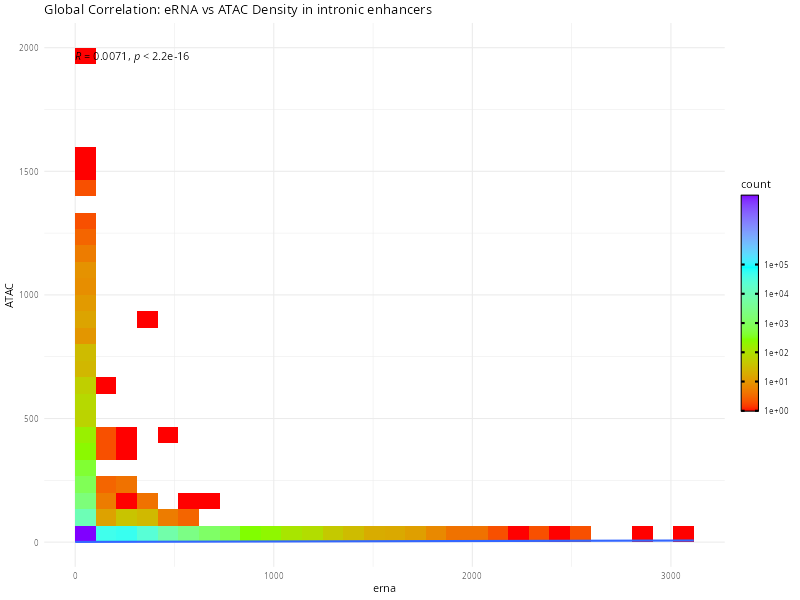

In [38]:
intergenic_enhancers = filter(enhancers_metadata, gene_intersection == "intronic")$id
intergenic_enhancers = intersect(intergenic_enhancers, rownames(rna_enhancers))
length(intergenic_enhancers)
df = data.frame(
  eRNA = as.vector(rna_enhancers[intergenic_enhancers, ]),
  ATAC = as.vector(atac_norm[intergenic_enhancers, ])
)
dim(df)
library(ggpubr)
library(scales)
my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
my_values <- rescale(log10(my_breaks), type = "q")

ggplot(df, aes(x = eRNA, y = ATAC)) +
  geom_bin2d(bins = 30) +
  scale_fill_gradientn(colors  = rainbow(4),values = my_values,
  breaks = my_breaks ,trans = "log10") +
  guides(fill = guide_colorbar(
    ticks.colour = "black",
    ticks.linewidth = 1,   
    frame.colour = "black",
    barheight = 15         
  ))+
  #geom_point(alpha = 0.3) +
  theme_minimal() +
  labs(title = "Global Correlation: eRNA vs ATAC Density in intronic enhancers",x = "erna", y= "ATAC")+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor()

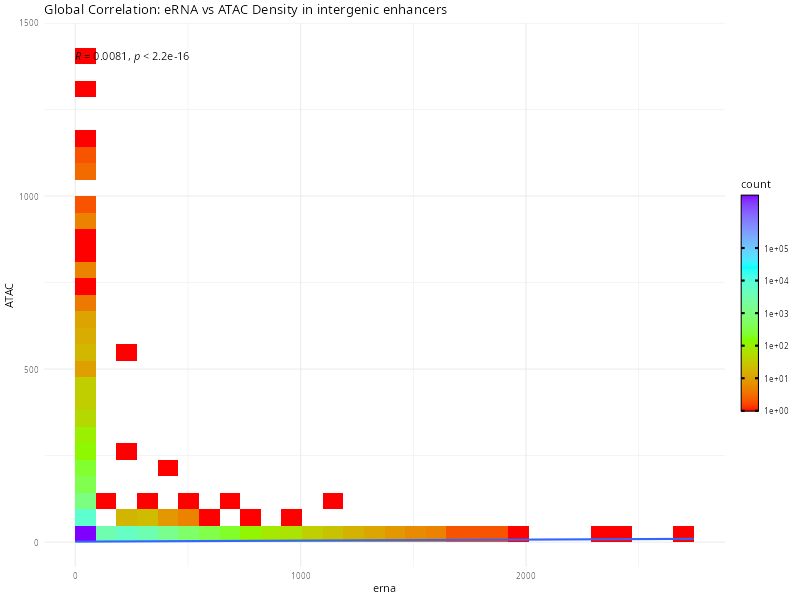

In [40]:
intergenic_enhancers = filter(enhancers_metadata, gene_intersection == "intergenic")$id
intergenic_enhancers = intersect(intergenic_enhancers, rownames(rna_enhancers))
length(intergenic_enhancers)
df = data.frame(
  eRNA = as.vector(rna_enhancers[intergenic_enhancers, ]),
  ATAC = as.vector(atac_norm[intergenic_enhancers, ])
)
dim(df)
library(ggpubr)
library(scales)
my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
my_values <- rescale(log10(my_breaks), type = "q")

ggplot(df, aes(x = eRNA, y = ATAC)) +
  geom_bin2d(bins = 30) +
  scale_fill_gradientn(colors  = rainbow(4),values = my_values,
  breaks = my_breaks ,trans = "log10") +
  guides(fill = guide_colorbar(
    ticks.colour = "black",
    ticks.linewidth = 1,   
    frame.colour = "black",
    barheight = 15         
  ))+
  #geom_point(alpha = 0.3) +
  theme_minimal() +
  labs(title = "Global Correlation: eRNA vs ATAC Density in intergenic enhancers",x = "erna", y= "ATAC")+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor()

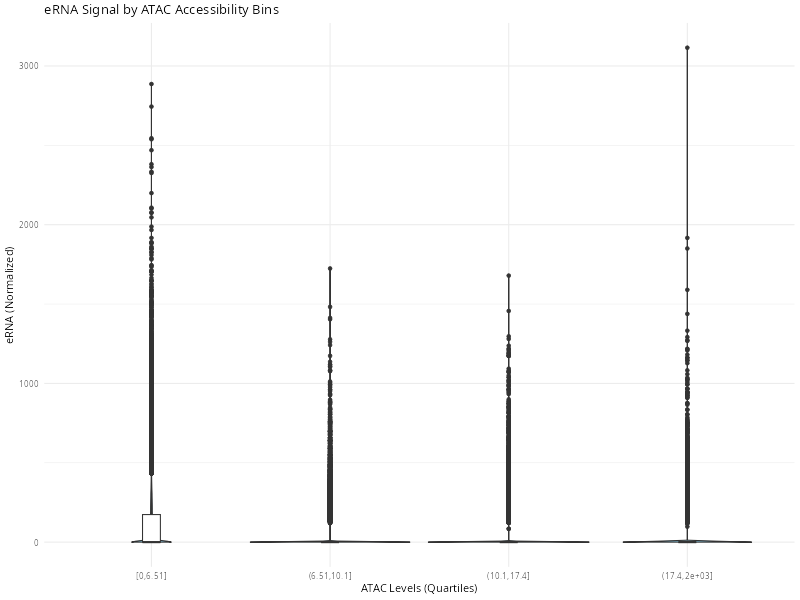

In [41]:
# Example logic for the next plot
df_corr <- data.frame(
  eRNA = as.vector(rna_enhancers),
  ATAC = as.vector(atac_norm)
)

# Filter out double zeros to see actual signal
df_corr <- df_corr[df_corr$eRNA > 0 | df_corr$ATAC > 0, ]

# Create ATAC bins
df_corr$ATAC_bin <- cut(df_corr$ATAC, breaks = quantile(df_corr$ATAC, probs = seq(0, 1, 0.25)), include.lowest = TRUE)

ggplot(df_corr, aes(x = ATAC_bin, y = eRNA)) +
  geom_violin(fill = "skyblue") +
  geom_boxplot(width = 0.1) +
  theme_minimal() +
  labs(title = "eRNA Signal by ATAC Accessibility Bins", x = "ATAC Levels (Quartiles)", y = "eRNA (Normalized)")

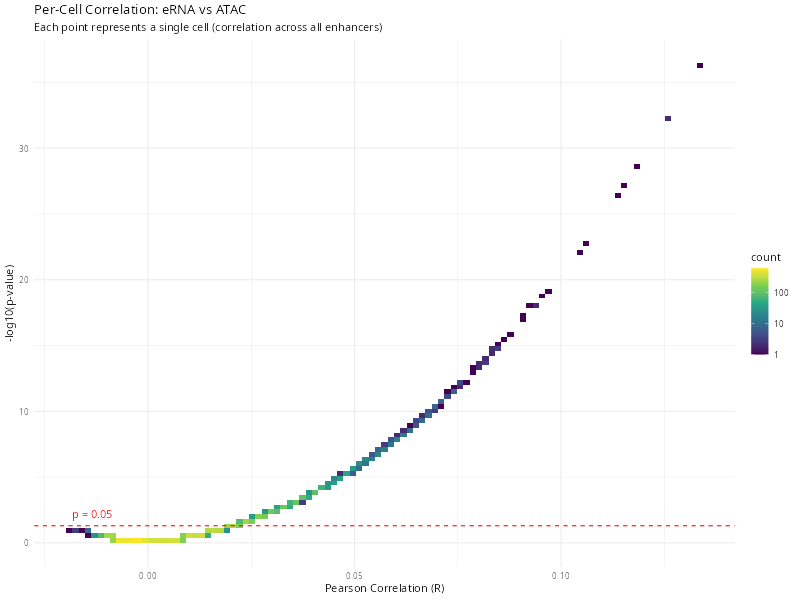

In [36]:

# 1. Calculate R and P-value for each cell (column)
# Assumption: rna_enhancers and atac_counts are matrices where 
# Rows = Enhancers and Columns = Cells.
cell_results <- sapply(1:ncol(rna_enhancers), function(i) {
  
  # Run Pearson correlation test between eRNA and ATAC for cell 'i'
  # We use use = "complete.obs" to handle potential NA values
  res <- cor.test(rna_enhancers[, i], atac_norm[, i], method = "pearson")
  
  # Return a vector containing the correlation coefficient (R) and the p-value
  return(c(R = res$estimate, pval = res$p.value))
})

# 2. Reformat the results into a Data Frame
# t() transposes the matrix so that each row represents one cell
cell_df <- as.data.frame(t(cell_results))
colnames(cell_df) <- c("R", "pvalue")

# 3. Add a column for -log10(p-value) for the Y-axis
# We add a tiny offset (1e-300) to avoid log(0) calculation for very small p-values
cell_df <- cell_df %>%
  mutate(log10p = -log10(pvalue + 1e-300))

# 4. Generate the Scatterplot
ggplot(cell_df, aes(x = R, y = log10p)) +
  # Use semi-transparent points to visualize density (useful for 5K-10K cells)
  geom_bin2d(bins = 100) +
  scale_fill_viridis_c(trans = "log10")+
  # Add a horizontal dashed line for the significance threshold (p = 0.05)
  # -log10(0.05) is approximately 1.3
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  
  # Add visual themes and labels
  theme_minimal() +
  labs(
    title = "Per-Cell Correlation: eRNA vs ATAC",
    subtitle = "Each point represents a single cell (correlation across all enhancers)",
    x = "Pearson Correlation (R)",
    y = "-log10(p-value)"
  ) +
  
  # Add a text label for the significance threshold
  annotate("text", x = min(cell_df$R), y = -log10(0.05), 
           label = "p = 0.05", color = "red", vjust = -1, hjust = 0)


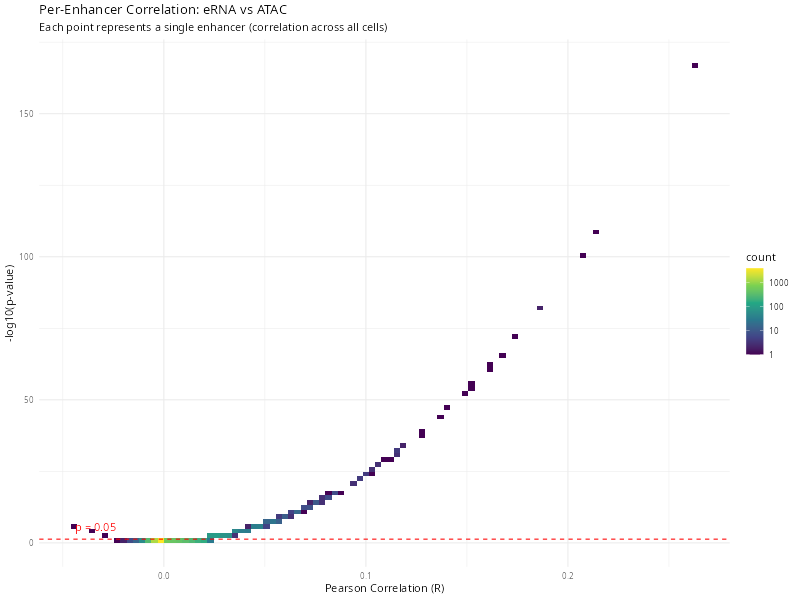

In [37]:

# 1. Calculate R and P-value for each cell (column)
cell_results <- sapply(1:nrow(rna_enhancers), function(i) {
  
  # Run Pearson correlation test between eRNA and ATAC for cell 'i'
  # We use use = "complete.obs" to handle potential NA values
  res <- cor.test(rna_enhancers[i, ], atac_norm[i, ], method = "pearson")
  
  # Return a vector containing the correlation coefficient (R) and the p-value
  return(c(R = res$estimate, pval = res$p.value))
})

# 2. Reformat the results into a Data Frame
# t() transposes the matrix so that each row represents one cell
cell_df <- as.data.frame(t(cell_results))
rownames(cell_df) <- rownames(rna_enhancers)
colnames(cell_df) <- c("R", "pvalue")

# 3. Add a column for -log10(p-value) for the Y-axis
# We add a tiny offset (1e-300) to avoid log(0) calculation for very small p-values
cell_df <- cell_df %>%
  mutate(log10p = -log10(pvalue + 1e-300))

# 4. Generate the Scatterplot
ggplot(cell_df, aes(x = R, y = log10p)) +
  # Use semi-transparent points to visualize density (useful for 5K-10K cells)
  geom_bin2d(bins = 100) +
  scale_fill_viridis_c(trans = "log10")+
  # Add a horizontal dashed line for the significance threshold (p = 0.05)
  # -log10(0.05) is approximately 1.3
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  
  # Add visual themes and labels
  theme_minimal() +
  labs(
    title = "Per-Enhancer Correlation: eRNA vs ATAC",
    subtitle = "Each point represents a single enhancer (correlation across all cells)",
    x = "Pearson Correlation (R)",
    y = "-log10(p-value)"
  ) +
  
  # Add a text label for the significance threshold
  annotate("text", x = min(cell_df$R), y = -log10(0.05), 
           label = "p = 0.05", color = "red", vjust = -1, hjust = 0)


# Binarize

In [44]:
rna_enhancers = original_rna_mat %>% as.matrix()
atac_norm = original_atac_mat %>% as.matrix() 

In [45]:
# binarize the data
atac_norm[atac_norm<binarize_threshold] <- 0
atac_norm[atac_norm>=binarize_threshold] <- 1

rna_enhancers[rna_enhancers<binarize_threshold] <- 0
rna_enhancers[rna_enhancers>=binarize_threshold] <- 1


In [46]:
# remove all 0 cells
zero_cells = colSums(atac_norm) == 0 | colSums(rna_enhancers) == 0
atac_norm = atac_norm[, !zero_cells]
rna_enhancers = rna_enhancers[, !zero_cells]

# remove all 0 enhancers
zero_enhancers = rowSums(atac_norm) == 0 | rowSums(rna_enhancers) == 0
atac_norm = atac_norm[!zero_enhancers, ]
rna_enhancers = rna_enhancers[!zero_enhancers, ]

In [47]:
print(dim(atac_norm))
dim(rna_enhancers)

[1]  2590 10492


[1]  2590 10492

In [48]:
# Jaccard Index = TP / (TP + FP + FN)
calculate_jaccard <- function(v1, v2) {
    # Check for perfect length match (safety check)
    if (length(v1) != length(v2)) stop("Vectors must be of equal length.")
    
    # True Positives (TP): Both are 1
    TP <- sum(v1 == 1 & v2 == 1)
    
    # Union Size (TP + FP + FN): At least one is 1
    union_size <- sum(v1 == 1 | v2 == 1)
    # Handle the edge case where a cell has zero activity across all 11,909 enhancers
    if (union_size == 0) return(0)  
    return(TP / union_size)
}

In [49]:
phi_per_cell <- mapply(function(x, y){cor(x, y)}, as.data.frame(rna_enhancers), as.data.frame(atac_norm))


In [50]:

head(phi_per_cell)

AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT AAACAGCCACCAACCG AAACAGCCAGGATAAC AAACAGCCAGTTTACG 
    -0.020896449     -0.020472058     -0.002510461     -0.009955691      0.043716993      0.050757467 

In [51]:
jaccard_per_cell = mapply(function(x, y){calculate_jaccard(x, y)}, as.data.frame(rna_enhancers), as.data.frame(atac_norm))

In [52]:
head(jaccard_per_cell)

AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT AAACAGCCACCAACCG AAACAGCCAGGATAAC AAACAGCCAGTTTACG 
      0.00000000       0.00000000       0.00000000       0.00000000       0.01219512       0.02083333 

In [53]:
results_df <- data.frame(
    Phi = phi_per_cell,
    Jaccard = jaccard_per_cell
)

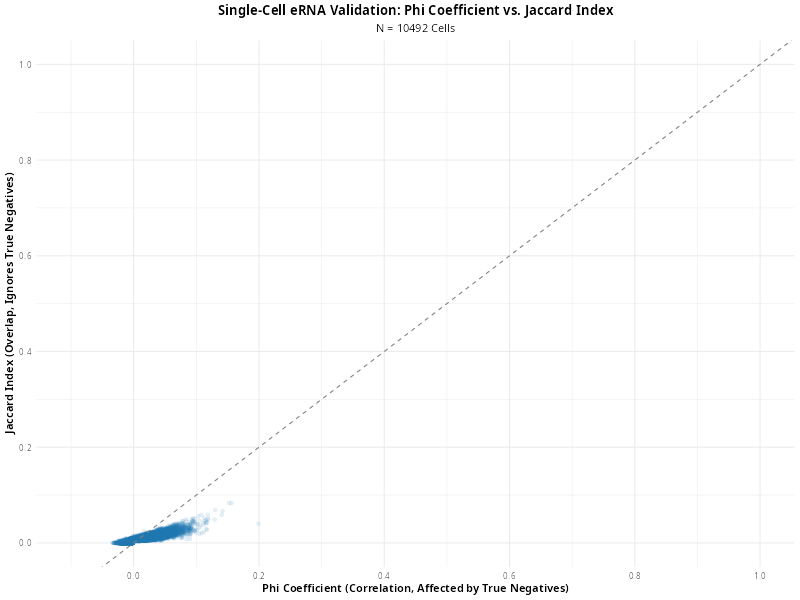

In [54]:
ggplot(results_df, aes(x = Phi, y = Jaccard)) +
    
    # 1. Scatter points with transparency (crucial for large datasets)
    # Using geom_point with high alpha to show point density.
    geom_point(alpha = 0.1, size = 1.5, color = "#1f78b4") + 
    

    
    # 3. Add the identity line (y = x) for comparison
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray50") +
    
    # 4. Define axis limits and labels
    scale_x_continuous(limits = c(-0.1, 1), breaks = seq(0, 1, 0.2)) + 
    scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2)) + 
    
    labs(
        title = "Single-Cell eRNA Validation: Phi Coefficient vs. Jaccard Index",
        subtitle = paste0("N = ", nrow(results_df), " Cells"),
        x = "Phi Coefficient (Correlation, Affected by True Negatives)",
        y = "Jaccard Index (Overlap, Ignores True Negatives)"
    ) +
    
    # 5. Apply a clean theme
    theme_minimal() +
    theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.title = element_text(face = "bold")
    )

In [55]:

contingency_table <- table(c(as.matrix(atac_norm)),c(as.matrix(rna_enhancers)))
contingency_table

   
           0        1
  0 25375144   134757
  1  1648355    16024

In [56]:
test <- fisher.test(contingency_table)
test


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.800534 1.860849
sample estimates:
odds ratio 
  1.830479 


In [57]:
# histogram of fisher per cell p-values with ggplot2
library(ggplot2)
fisher_per_cell_test = function(x, y){
    fisher.test(table(x, y))$p.value
}
fisher_per_cell = mapply(fisher_per_cell_test, as.data.frame(rna_enhancers), as.data.frame(atac_norm))



[1] "Number of cells with significant association (FDR < 0.05): 6 out of 10492"


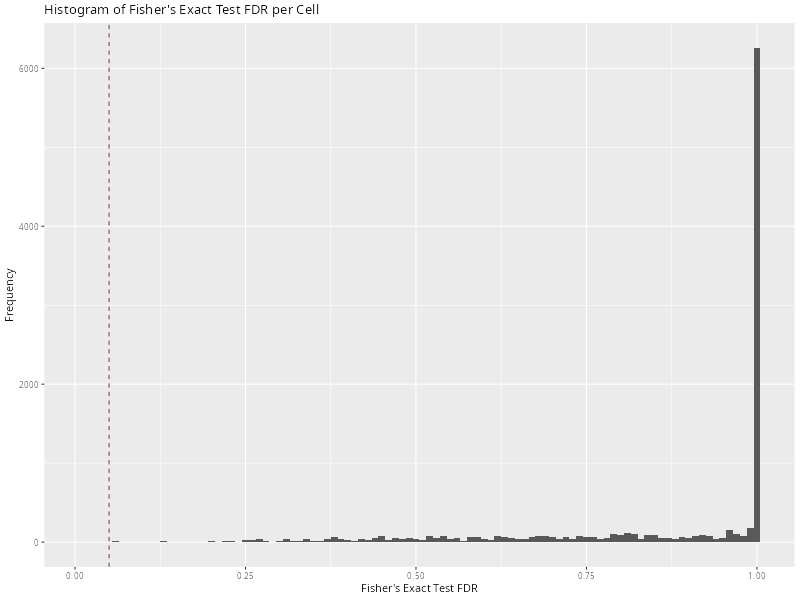

In [58]:
# create a data frame for plotting
fisher_df = data.frame(fdr = p.adjust(fisher_per_cell,method = "fdr"))

# plot the histogram
ggplot(fisher_df, aes(x = fdr)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Fisher's Exact Test FDR") +
    ylab("Frequency") +
    # add line at 0.05 significance level
    geom_vline(xintercept = 0.05, color = "#8a3c3c", linetype = "dashed") +
    ggtitle("Histogram of Fisher's Exact Test FDR per Cell")

#count cells with significant FDR < 0.05
significant_cells = sum(fisher_df$fdr < 0.05)
print(paste0("Number of cells with significant association (FDR < 0.05): ", significant_cells, " out of ", length(fisher_per_cell)))

In [ ]:
# histogram of fisher per enhancer p-values with ggplot2
library(ggplot2)
fisher_per_enhancer_test = function(x, y){
    tryCatch(fisher.test(table(x, y))$p.value, error = function(e) NA)
}
fisher_per_enhancer = mapply(fisher_per_enhancer_test, as.data.frame(t(rna_enhancers)), as.data.frame(t(atac_norm)))



[1] "Number of enhancers with significant association (FDR < 0.05): 8 out of 2098"


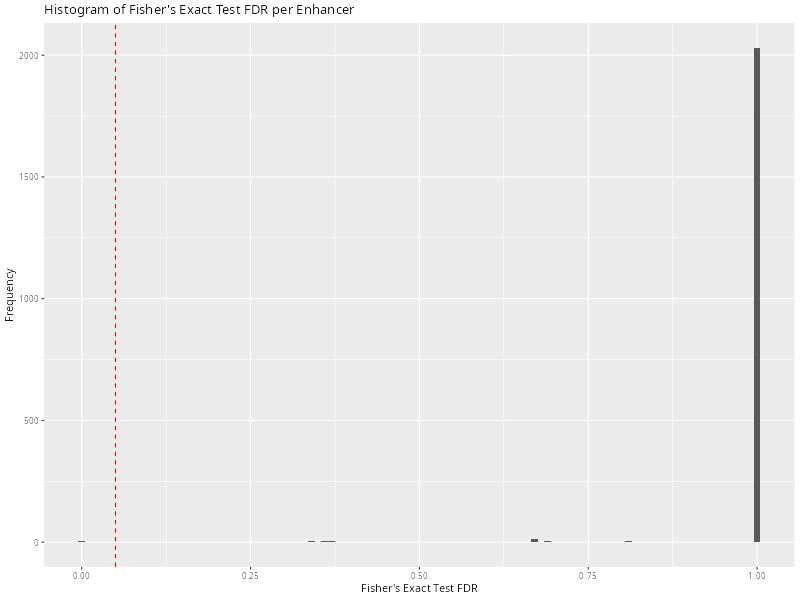

In [91]:
fisher_per_enhancer = na.omit(fisher_per_enhancer)
# create a data frame for plotting
fisher_df = data.frame(fdr = p.adjust(fisher_per_enhancer,method = "fdr"))

# plot the histogram
ggplot(fisher_df, aes(x = fdr)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Fisher's Exact Test FDR") +
    ylab("Frequency") +
    # add line at 0.05 significance level
    geom_vline(xintercept = 0.05, color = "red", linetype = "dashed") +
    ggtitle("Histogram of Fisher's Exact Test FDR per Enhancer")

#count enhancers with significant FDR < 0.05
significant_enhancers = sum(fisher_df$fdr < 0.05)
print(paste0("Number of enhancers with significant association (FDR < 0.05): ", significant_enhancers, " out of ", length(fisher_per_enhancer)))